In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import numpy as np
from foe_lib import *

## Creating a Test Optical Flow Pattern from motion field equation
The start of our notebook, will look at the generation of an optical flow from the motion field equation. We will then used the Heeger-Jepson, method in order to produce a candidate $\Omega$, $V$ distribution over which we can search. 

$\dot{p}=\frac{1}{Z}\begin{pmatrix}
   -f & 0 & x\\
  0 & -f & y 
  \end{pmatrix} T+\begin{pmatrix}
  (xy)/f & -(f+x^2/f) & y\\
  f+y^2/f & -(xy)/f & -x 
  \end{pmatrix}\Omega=\frac{1}{Z}A(x,y)T +B(x,y)\Omega\\
  $

In [2]:
# Motion of the Camera
T_unorm = jnp.array([0, 0, 2])
T = T_unorm  # / jnp.linalg.norm(T_unorm)
Ω = jnp.array([0, 0, 0])

# Intrinsic Parameters
res = (100, 100)
f = 1

# Depth Value at each pixel
min_depth = 5  # Example depth ranges
max_depth = 10
Z = jax.random.uniform(
    jax.random.PRNGKey(0), (res[0] * res[1], 1), minval=min_depth, maxval=max_depth
)
K = jnp.array([[f, 0, res[0] / 2], [0, f, res[1] / 2], [0, 0, 1]])
K_inv = jnp.linalg.inv(K)

### Create A Matrix
In computer vision, you can choose the projective coordinate system to use, either the pixel coordinates(x', y', 1) or normalized coordinates(x,y,1). Tradational coordinates have a focal length=f, while in normalzied coordinates transform our coordinates such that f=1. Throughout this work, we will use normalized coordinates. 

Vmap is a function in Jax that allows for us to perform an operation over an array of the array. In this example, we will take our coordinate array of size: (res[0]*res[1],2) and map over the first dimension. This means our function specified in vmap will be evaulated for each res[0]*res[1] with 2 value input. We can then right a  function that takes this 2 coordinate input(x,y) and transforms it into our A matrix. The output then will be stacked for each pixel and we have the total output.


$\begin{pmatrix}
x \\ y \\ 1
  \end{pmatrix}=K^{-1}\begin{pmatrix}
   x' \\ y' \\ 1
  \end{pmatrix}$

$A=\begin{pmatrix}
   -f & 0 & x\\
  0 & -f & y 
  \end{pmatrix}$

In [3]:
y = jnp.arange(0, res[0])
x = jnp.arange(0, res[1])
xx, yy = jnp.meshgrid(x, y)


def create_A_matrix(cord, f):
    return jnp.array([[-f, 0, cord[0]], [0, -f, cord[1]]])


cam_pts = jnp.stack([xx.flatten(), yy.flatten(), jnp.ones(res[0] * res[1])])
norm_cords = K_inv @ cam_pts
create_A = jax.vmap(create_A_matrix, in_axes=(1, None), out_axes=0)
A = create_A(norm_cords, 1)  # (res[0] * res[1], 2, 3)
# In this case remeber f=1, since we are working with normalized coordinates

### Create B Matrix
$B=\begin{pmatrix}
  (xy)/f & -(f+x^2/f) & y\\
  f+y^2/f & -(xy)/f & -x 
  \end{pmatrix}$

In [4]:
def create_B_matrix(cord, f):
    return jnp.array(
        [
            [(cord[0] * cord[1]), -(f + (cord[0] ** 2) / f), cord[1]],
            [f + (cord[1] ** 2) / f, -(cord[0] * cord[1]) / f, -cord[0]],
        ]
    )


create_B = jax.vmap(create_B_matrix, in_axes=(1, None), out_axes=0)
B = create_B(norm_cords, 1)  # (res[0] * res[1], 2, 3)

# In this case remeber f=1, since we are working with normalized coordinates

### Perform the full calculation

$\dot{p}=\frac{1}{Z}A(x,y)T +B(x,y)\Omega$

In [5]:
### Calculate the motion field
v = (1 / Z) * (A @ T) + B @ Ω  # (res[0] * res[1], 2)
flow = v.reshape(res[0], res[1], 2)  # (res[0], res[1], 2)

Text(0.5, 1.0, 'Pure Z Translational Flow Field')

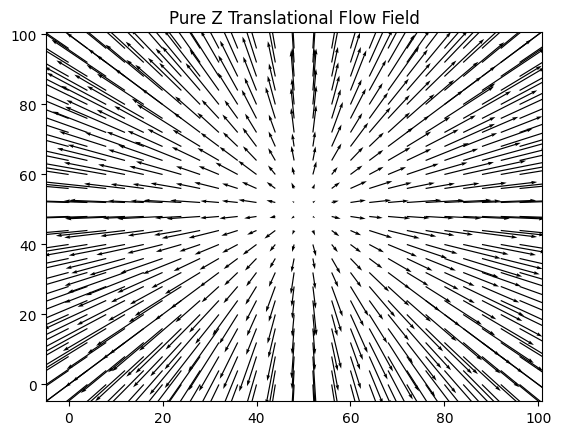

In [6]:
def plot_ff(flow):
    spacing = 4
    xval = np.arange(0, flow.shape[1], spacing)
    yval = np.arange(0, flow.shape[0], spacing)
    xx, yy = np.meshgrid(xval, yval)

    plt.quiver(
        xx,
        yy,
        flow[::spacing, ::spacing, 0],
        flow[::spacing, ::spacing, 1],
        scale=1,
        scale_units="xy",
        angles="xy",
        units="xy",
    )


plot_ff(flow)
plt.title("Pure Z Translational Flow Field")

### Some Other Example Flow Patterns

Text(0.5, 1.0, 'Combined')

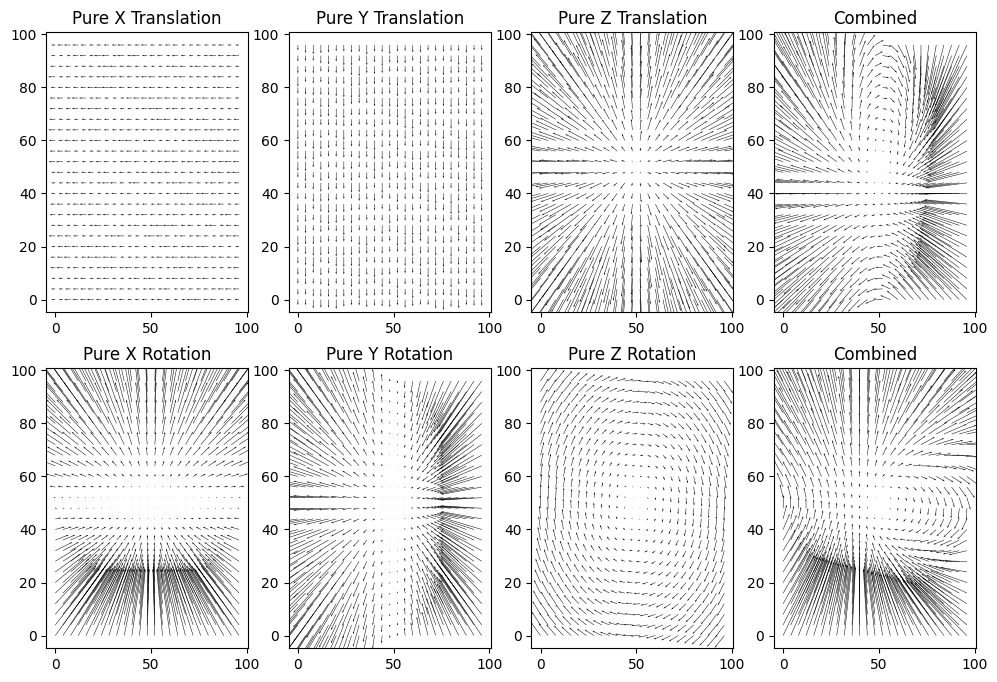

In [7]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 4, 1)
T_x = jnp.array([20, 0, 0])
v = (1 / Z) * (A @ T_x) + B @ Ω
flow = v.reshape(res[0], res[1], 2)
plot_ff(flow)
plt.title("Pure X Translation")

plt.subplot(2, 4, 2)
T_y = jnp.array([0, 20, 0])
v = (1 / Z) * (A @ T_y) + B @ Ω
flow = v.reshape(res[0], res[1], 2)
plot_ff(flow)
plt.title("Pure Y Translation")

plt.subplot(2, 4, 3)
T_z = jnp.array([0, 0, 2])
v = (1 / Z) * (A @ T_z) + B @ Ω
flow = v.reshape(res[0], res[1], 2)
plot_ff(flow)
plt.title("Pure Z Translation")

plt.subplot(2, 4, 4)
T_tot = jnp.array([0.0, 0.1, 0.1])

Ω_tot = jnp.array([0.0, 0.01, 0.1])
v = (1 / Z) * (A @ T_tot) + B @ Ω_tot
flow = v.reshape(res[0], res[1], 2)
plot_ff(flow)
plt.title("Combined")

plt.subplot(2, 4, 5)
T_null = jnp.array([0, 0, 0])
Ω_x = jnp.array([0.01, 0, 0])
v = (1 / Z) * (A @ T_null) + B @ Ω_x
flow = v.reshape(res[0], res[1], 2)
plot_ff(flow)
plt.title("Pure X Rotation")

plt.subplot(2, 4, 6)
Ω_y = jnp.array([0, 0.01, 0])
v = (1 / Z) * (A @ T_null) + B @ Ω_y
flow = v.reshape(res[0], res[1], 2)
plot_ff(flow)
plt.title("Pure Y Rotation")

plt.subplot(2, 4, 7)
Ω_z = jnp.array([0, 0, 0.1])
v = (1 / Z) * (A @ T_null) + B @ Ω_z
flow = v.reshape(res[0], res[1], 2)
plot_ff(flow)
plt.title("Pure Z Rotation")

plt.subplot(2, 4, 8)
T_tot = jnp.array([0.1, 0, 0.1])

Ω_tot = jnp.array([0.01, 0, 0.1])
v = (1 / Z) * (A @ T_tot) + B @ Ω_tot
flow = v.reshape(res[0], res[1], 2)
plot_ff(flow)
plt.title("Combined")

## Egomotion Recovery: Heeger and Jepson
$$
\begin{align*}
e &= \min_{T,\Omega,\frac{1}{Z}} \left\| \frac{1}{Z} A(x, y) T + B \Omega - V \right\|_2 \\
% Factorize minimization + A(x, y) T = A(T) \\
&\stackrel{\text{Factorize}}{=} \min_{T, \Omega} \min_{\frac{1}{Z}}  \left\| \frac{1}{Z} A(T) + B \Omega - V \right\|_2 \\
% Assume known (T, Omega) solve for 1/Zi
&\text{Assume known } (T, \Omega) \text{, solve for } \frac{1}{Z} \\
& A(T) \frac{1}{Z} = V - B\Omega  \\
& \frac{1}{Z} = (A(T)^T A(T))^{-1} A(T)^T (V - B\Omega) \\
% Minimize (I-A(T)(A(T))^T A(T)^T)(v-B\Omega) \\
% This is just the orthogonal projection A(T)^\perp
&= \min \left( I - A(T) (A(T)^T A(T))^{-1} A(T)^T \right) (V - B\Omega) \\
&\quad\text{This is just the orthogonal projection } A(T)^\perp \\
% Minimize A^perp(T)^T(v-B\Omega)
&= \min_{T, \Omega} A^{\perp}(T) (V - B \Omega) \\
% LSQ Estimate: hat{\Omega}(t)
% Minimize ||A^perp(T)^T(B\hat{\Omega}(T)-v)||
&= \min_T ||A^{\perp}(T) (B \hat{\Omega}(T) - V)||_2
\end{align*}
$$

In [8]:
# Flow we will use for the calculation
T_tot = jnp.array([0.1, 0, 0.1])  # (3,1)
Ω_tot = jnp.array([0.01, 0, 0.1])  # (3,1)
v = (1 / Z) * (A @ T_tot) + B @ Ω_tot
# Z: (res[0] * res[1], 1), A: (res[0] * res[1], 2, 3)
# T: (3,1), B: (res[0] * res[1], 2, 3), Ω: (3,1)

flow = v.reshape(res[0], res[1], 2)  # (res[0],res[1],2)

### Step 1: Starting computation of $A^{\perp}(T)=JAT, JA \in R^{3 \times 2}: \begin{pmatrix} 0 & -f & y \\ f & 0 & -x \\ \end{pmatrix}$

We would like to find $A^\perp(T)$, from [Introduction to Linear Algebra](https://math.mit.edu/~gs/linearalgebra/ila6/indexila6.html) you can find that the definition of the orthogonal subspace is the nullspace of $A^T(T)$, hence we are looking for a vector: N(T^T A^T). $T^TA^T \in \mathbb{R}^{1\times 2}$. Imagine for a moment this vector has values: $\epsilon[\alpha, \beta]^T $. A trival vector orthogonal to this is $\gamma=[-\beta,\alpha], \epsilon \gamma=0 $. One way is to define an operator $J=\begin{pmatrix} 0 & 1\\ -1 & 0 \end{pmatrix}$, then the orthogonal complement is just $A^\perp(T)=JAT$. In just this function we will compute JA, next we will do the projection of T.

In [9]:
def create_A_perp_matrix(cord, f):
    return jnp.array([[0, -f, cord[1]], [f, 0, -cord[0]]])


create_A_perp = jax.vmap(create_A_perp_matrix, in_axes=(1, None), out_axes=0)
A_perp = create_A_perp(norm_cords, 1)  # (Pts, 2, 3)

### Step 2: Calculate $A^{\perp}(T)=\frac{JAT}{|JAT|}$
Before we can proceed to calculate $A^\perp(T)$, we need to create a candidate list of directions to search over in order to find a possible minimum solution. Various solutions have been presented in the literature for sampling points on the unit postive hemisphere, some linked bellow. In the approach we will present, we will work in spherical coordinates and select two angles ($\phi, \theta$) randomly and using the spherical to cartesian coordinate transform, we now will have points uniformly distributed one the sphere.
Remeber |T|=1, in our minimization scenario
Some example stradegies:
- [Sphere Point Picking
](https://mathworld.wolfram.com/SpherePointPicking.html)
- [How to generate equidistributed points on the surface of a sphere](https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf)
- [Choosing a Point from the Surface of a Sphere](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-43/issue-2/Choosing-a-Point-from-the-Surface-of-a-Sphere/10.1214/aoms/1177692644.full)

![Circle Sampling](imgs/circle.png)


After calculating the search direction, we will project JA on T, and then we will normalize each element of the matrix. 


In [10]:
def generate_random_points_on_positive_hemisphere(num_points):
    """Generate num_points random points on the positive hemisphere in R^3"""
    points = np.zeros((num_points, 3))
    for i in range(num_points):
        # Generate random point on positive hemisphere using spherical coordinates
        phi = np.random.uniform(0, 2 * np.pi)  # azimuthal angle
        u = np.random.uniform()  # random value between 0 and 1
        theta = np.arccos(u)  # polar angle
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        points[i] = [x, y, z]
    return np.vstack([points[:, 0], points[:, 1], points[:, 2]])

In [11]:
T_search = generate_random_points_on_positive_hemisphere(1000)
# T: (3, # Dirs)

In [12]:
A_perp_T = A_perp @ T_search
#  A_perp (# pts, 2, 3), T: (3, # Dirs), Out: (# pts, 2, # Dirs)

In [13]:
tmp_rearange = A_perp_T.transpose(1, 0, 2)  # A_perp_T(Rearanged) (2, # pts, # Dirs)
A_perp_T_norm = tmp_rearange / (
    jnp.linalg.norm(tmp_rearange, axis=0)[None, :, :] + 1e-10
)  # A_perp_T_norm (2, # pts, Dirs)

### Step 3: Calculate  $A^{\perp}(T)V$

In [14]:
V = flow.reshape(-1, 2)  # flow: (res[0],res[1],2 )-> V: (#pts(res[0]*res[1]), 2)
A_perp_T_V = jnp.sum(
    A_perp_T_norm.transpose(1, 0, 2) * V[:, :, None], axis=1
)  # (#pts,2,#Dirs) x (#pts,2,1)= \sum_a1 (#pts,2,#Dirs)= (#pts,#Dirs)

### Step 4: Calculate $A^{\perp}(T)B$

In [15]:
A_perp_T_B = jnp.sum(
    A_perp_T_norm.transpose(1, 0, 2)[:, :, None, :] * B[:, :, :, None], axis=1
)  # (#pts,2,1,#Dirs) x (#pts,2,3, 1)= \sum_a1 (#pts,2,3,#Dirs)= (#pts,3, #Dirs)

### Step 5: Calculate $((A^{\perp}(T)B)^TA^{\perp}(T)B)^{-1}$

We want to calculate: $ $A^{\perp}(T)B \hat{\Omega}(T) = A^{\perp}(T)v$. Note that this system is overdetermined so, we will use the psudeo inverse for the solution. Therefore, we will calculate: $\hat{\Omega}(T)=\textcolor{red}{((A^{\perp}(T)B)^TA^{\perp}(T)B)^{-1}}\textcolor{green}{(A^{\perp}(T)B)^{T}A^{\perp}(T)v}$. We will compute these two term independly, in this step we will compute the $\textcolor{red}{red}$ term.


Again we use vmap here to calculate this matrix inverse for each of the T directions.

In [16]:
def calc_inverse(A_p_T_B):
    return jnp.linalg.inv(A_p_T_B.T @ A_p_T_B)


inv_func = jax.vmap(calc_inverse, in_axes=(2))
A_perp_T_B_inv = inv_func(A_perp_T_B)  # (#pts,3, #Dirs) -> (#Dirs,3,3)

### Step 6: Calculate $(A^{\perp}(T)B)^T (A^{\perp}(T)V)$
In our next step we will compute $\textcolor{green}{green}$ term from the above.

In [17]:
A_perp_T_B_A_perp_T_V = jax.lax.batch_matmul(
    A_perp_T_B.transpose(2, 1, 0), A_perp_T_V.T[:, :, None]
)[:, :, 0].T
# Mutiplication over all the points
# A_perp_T_B:(#pts,3,#Dirs),
# A_perp_T_V:(#pts,#Dirs),
# A_perp_T_B_A_perp_T_V: (3, #Dirs)

### Step 7:  Solve for $\Omega$
 $\hat{\Omega}(T)=\textcolor{red}{((A^{\perp}(T)B)^TA^{\perp}(T)B)^{-1}}\textcolor{green}{(A^{\perp}(T)B)^{-1}A^{\perp}(T)v}$

Here we will use the batch matrix mutiplication function, which will perform a matrix mutiplication over the first dimension and stack the outputs

In [18]:
Omega = jax.lax.batch_matmul(A_perp_T_B_inv, A_perp_T_B_A_perp_T_V.T[:, :, None])[
    :, :, 0
]

# A_perp_T_B_inv: (#Dirs,3,3),
# A_perp_T_B_A_perp_T_V: (3, #Dirs)
# Omega: (#Dirs,3)

## Step 7: Calculating the residual

$||A^{\perp}(T)B \hat{\Omega}(T) - A^{\perp}(T)V)||_2$

In [19]:
A_perp_B_omega = jnp.sum(A_perp_T_B * Omega[:, :, None].T, axis=1)
#  A_perp_T_B: (#pts,3,#Dirs), Omega: (#Dirs,3)
# A_perp_B_omega: (#pts, #dirs)
# A_perp_T_V: (#pts, #dirs)

flow_res = (A_perp_B_omega - A_perp_T_V) ** 2  # calculates residual
tot_res = jnp.sum(flow_res, axis=0)  # sum up over all points

Select the minimum value: $\min_T ||A^{\perp}(T)B \hat{\Omega}(T) - A^{\perp}(T)V)||_2$

In [20]:
min_idx = jnp.argmin(tot_res)
T_min = T_search[:, min_idx]
Omega_min = Omega[min_idx]

In [21]:
A1 = proj_T_vm(A_perp.transpose(0, 2, 1), T_search)
assert jnp.sum(A_perp_T.transpose(1, 0, 2) - A1) < 1e-3

A1_norm = A1 / (jnp.linalg.norm(A1, axis=(0))[None, :, :] + 1e-10)
assert jnp.sum(A_perp_T_norm - A1_norm) < 1e-3

apbv2 = crt_aprp_v2(A1_norm, V.T)  # Confirmed works
assert jnp.all(jnp.sum(apbv2 - A_perp_T_V.T) < 1e-3)


big_B = big_b(norm_cords[:2, :])[:, :, :, 0]
tiled_B = big_B.reshape(-1, 3)
b_mat = jnp.stack(
    [
        tiled_B[:, 0].reshape(-1, 2),
        tiled_B[:, 1].reshape(-1, 2),
        tiled_B[:, 2].reshape(-1, 2),
    ],
    axis=1,
).reshape(-1, 2)
a_perp_b = crt_aprp_b2(A1_norm, b_mat)  # Confirmed Works
assert jnp.sum(A_perp_T_B - a_perp_b.transpose(1, 2, 0)) < 1e-3

a_perp_v = crt_aprp_v2(A1_norm, V.T)  # Confirmed Works
assert jnp.sum(A_perp_T_V.T - a_perp_v) < 1e-3

lhs_inv = calc_mat_inv(a_perp_b)  # Confirmed Works
assert jnp.sum(A_perp_T_B_inv - lhs_inv) < 1e-3

rhs_proj = project_a_b_v_vm(a_perp_b, a_perp_v)  # Confirmed Works
assert jnp.sum(A_perp_T_B_A_perp_T_V.T - rhs_proj) < 1e-3


omega = project_inv_vm(lhs_inv, rhs_proj)  # Off by a lot
assert jnp.sum(Omega - omega) < 1e-3

a_omega = a_omega_vm(a_perp_b, omega)
assert jnp.sum(A_perp_B_omega - a_omega.T) < 1e-3

flow_res2 = (a_omega - a_perp_v) ** 2
assert jnp.sum(flow_res2 - flow_res.T) < 1e-3

min_idx2 = jnp.argmin(jnp.sum(flow_res2, axis=1))
T_min2 = T_search[:, min_idx2]
Omega_min2 = omega[min_idx2]

assert jnp.all(T_min == T_min2)
assert jnp.all(Omega_min == Omega_min2)

### Step 8: Lets plot the residual
Showcase the estimated translation direction in red and the ground truth in green.

Text(0.5, 1.0, 'Residual over Translation Direction')

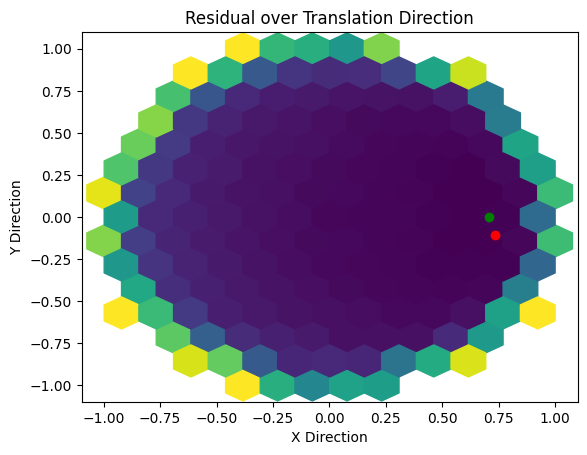

In [22]:
plt.hexbin(
    T_search[0],
    T_search[1],
    C=np.clip(tot_res, 0, np.quantile(tot_res, 0.85)),
    gridsize=13,
)
gt_dir = T_tot / jnp.linalg.norm(T_tot)
plt.scatter(T_min[0], T_min[1], c="red")
plt.scatter(gt_dir[0], gt_dir[1], c="green")

plt.xlabel("X Direction")
plt.ylabel("Y Direction")
plt.title("Residual over Translation Direction")

### Step 9
Now we will just verify that the calculated T and Omega, by comparing them to the ones we used to generate the original flow field!


In [23]:
print(T_min, T_tot / jnp.linalg.norm(T_tot))
print(Ω_tot, Omega_min)

[ 0.73177175 -0.1052992   0.67336631] [0.70710677 0.         0.70710677]
[0.01 0.   0.1 ] [ 9.9945683e-03 -2.0888322e-06  1.0000109e-01]


Step 10: Given the estimated T and Omega, lets calculate the scaled depth for comparsion. 

$\dot{p}=\frac{1}{Z}A(x,y)T +B(x,y)\Omega$  
$V-B(x,y)\Omega=C$  
$A(x,y)^{\dagger}(T)C=\frac{1}{Z}$  


In [24]:
# rot_corr_flow: (res[0]*res[1],2)
# B: (res[0]*res[1],2,3)
# Omega_min: (3)
rot_corr_flow = V - (B @ Omega_min)

In [25]:
# A: (res[0]*res[1],2,3)
# T_min: (3)
AT_min = A @ T_min

In [26]:
lhs_term = jnp.sum(rot_corr_flow * AT_min, axis=1)
rhs_term = jnp.sum(AT_min**2, axis=1)
inv_depth = lhs_term / (rhs_term + 1e-7)

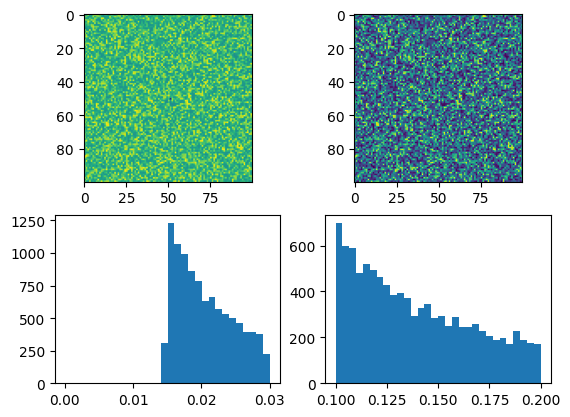

In [27]:
plt.subplot(2, 2, 1)
plt.imshow(inv_depth.reshape(res[0], res[1]))
plt.subplot(2, 2, 2)
plt.imshow(1 / Z[:, 0].reshape(res[0], res[1]))
plt.subplot(2, 2, 3)
_ = plt.hist(inv_depth, bins=30)
plt.subplot(2, 2, 4)
_ = plt.hist(1 / Z[:, 0], bins=30)